In [18]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
Image.MAX_IMAGE_PIXELS = 1000000000

In [45]:
# define functions for training (fine-tuning) and testing model
        
def finetune_ViT(model, trainloader, validationloader, optimizer, criterion, num_epochs, scheduler=None):
    
    m = nn.Sigmoid()
    tuning_parameters = [parameter for parameter in model.parameters() if parameter.requires_grad]
    
    avg_val_losses = []
    avg_training_losses = []
    epochs_finished = []
    
    # conditions for early stopping
    last_val_loss = float('inf')
    patience = 3
    es_counter = 0
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        
        model.train()
        if scheduler != None:
            print("Learning rate: ", scheduler.get_last_lr())
        
        running_loss = 0
        curr_total_train_loss = 0
        
        for i, data in enumerate(tqdm(trainloader, total=len(trainloader)), start=0):
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = m(outputs)
            
            loss = criterion(outputs, labels)
            curr_total_train_loss += loss.item()
            loss.backward()
            
            # perform grad clipping at global norm 1, as in ViT paper
            nn.utils.clip_grad_norm_(tuning_parameters, max_norm = 1)
            optimizer.step()
            
            # print statistics and current decayed learning rate
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0
        
        epochs_finished.append(epoch+1)
        avg_training_losses.append(curr_total_train_loss/len(trainloader))
        
        # step scheduler after every epoch        
        if scheduler != None:
            scheduler.step()
        
        # check for changes in total validation loss to determine if early stopping is needed
        print("Checking validation loss...")
        curr_val_loss = loss_validation(model, validationloader, criterion)
        avg_val_losses.append(curr_val_loss)
        print("Average validation loss after last epoch: ", curr_val_loss)
        
        if curr_val_loss > last_val_loss:
            es_counter += 1
            
            if es_counter >= patience:
                print("Early stopping triggered. Ending training..")
                return
            else:
                print(f"Increase in validation loss! {patience-es_counter} more consecutive loss increase(s) until early stop.")
        
        else:
            print("Decrease in validation loss. Early stop counter reset to 0.")
            es_counter = 0
            
        last_val_loss = curr_val_loss
        
        # check to save model if validation loss is lower than min recorded validation loss
        if curr_val_loss < min_val_loss:
            print("New best validation loss - saving model.")
            min_val_loss = curr_val_loss
            save_dir = "/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/trained_ViT.pth"
            torch.save(model.state_dict(), save_dir)
    
    # plot training and validation losses
    plt.plot(epochs_finished, avg_training_losses, label = "Training Loss")
    plt.plot(epochs_finished, avg_val_losses, label = "Validation Loss")
    plt.title("ViT Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

def test_ViT(model, testloader):
    model.eval()
    correct = 0
    total = 0
    
    m = nn.Sigmoid()
    
    with torch.no_grad():
        for data in testloader:
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = our_ViT(images)
            probabilities = m(outputs)
            
            predicted = torch.argmax(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc = correct/total * 100
        
    return acc

def loss_validation(model, validationloader, criterion=criterion):
    model.eval()
    total_val_loss = 0
    
    m = nn.Sigmoid()
    
    with torch.no_grad():
        for data in validationloader:
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = our_ViT(images)
            outputs = m(outputs)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss/len(validationloader)
    
    return avg_val_loss

In [20]:
def perform_hp_tuning(model, trainingset, validationset, lr_array, batchsize_array, criterion, num_epochs=1):

    accuracies = np.empty([len(lr_array), len(batchsize_array)])
    tuning_parameters = [parameter for parameter in model.parameters() if parameter.requires_grad]

    # run validation testing

    for i, lr in enumerate(lr_array):
        
        # reset optimizer with new learning rate
        optimizer = optim.SGD(tuning_parameters, lr=lr, momentum = .9)

        for j, batch_size in enumerate(batchsize_array):

            print("LEARNING RATE: ", lr)
            print("BATCH SIZE: ", batch_size)

            # restore original weights for ViT
            model.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth"))

            # define data loaders for training and testing data
            trainloader = torch.utils.data.DataLoader(trainingset, batch_size=batch_size, num_workers=2)
            testloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, num_workers=2)
            
            # train ViT using current hps
            finetune_ViT(model, trainloader=trainloader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs)

            # test performance on validation dataset
            result = test_ViT(model, testloader)

            accuracies[i,j] = result
            print(f"Accuracy for lr={lr} and bs={batch_size}: {accuracies[i,j]}\n")


    # choose learning rate and batch size with best validation accuracy
    print("---HP TESTING COMPLETE---")
    print("Accuracy Matrix: \n", accuracies)
    best_lr_ind, best_bs_ind = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
    
    optimal_lr = learning_rates[best_lr_ind]
    optimal_batch_size = batchsize_array[best_bs_ind]

    print(f"\nBest learning rate: {optimal_lr}")
    print(f"Best batch size: {optimal_batch_size}")
    return optimal_lr, optimal_batch_size

In [21]:
# fine-tuning helper methods

def freeze_layers(model):
    """
    Freeze all model layers
    """
    for param in our_ViT.parameters():
        param.requires_grad = False
            
def unfreeze_layers(model):
    """
    Reset requires_grad for all params
    """
    for param in our_ViT.parameters():
        param.requires_grad = True


In [22]:
# ----- timm Implemenation of ViT -----

In [23]:
# create ViT for art style classification
our_ViT = timm.create_model('vit_huge_patch14_224_in21k', pretrained = True, num_classes = 25)

# confirm changes in classifier output
our_ViT.get_classifier()

Removing representation layer for fine-tuning.


Linear(in_features=1280, out_features=25, bias=True)

In [24]:
# basic pre-processing tasks for proper ViT data ingestion

config = resolve_data_config({}, model=our_ViT)
transform = create_transform(**config)

In [25]:
# pre-training model setup

# freeze all layers of the ViT
freeze_layers(our_ViT)

# unfreeze desired layers for fine-tuning
our_ViT.head.bias.requires_grad = True
our_ViT.head.weight.requires_grad = True

# check that correct layers are frozen
for name, param in our_ViT.named_parameters():
    if param.requires_grad:
        print(name)


head.weight
head.bias


In [26]:
# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# save starting state for ViT
torch.save(our_ViT.state_dict(), "/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth")

our_ViT.to(device)

Device: cuda:0


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm

In [46]:
# initialize training dataset

trainpath = "/projectnb/dl523/projects/Sarcasm/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/train"
#trainpath = "/projectnb/dl523/students/kjv/EC520_Project/Data/wikipaintings_small/wikipaintings_train"
trainset = datasets.ImageFolder(trainpath, transform=transform)

# initialize validation dataset

validationpath = "/projectnb/dl523/students/kjv/EC520_Project/Data/wikipaintings_full/wikipaintings_val"
validationset = datasets.ImageFolder(validationpath, transform=transform)

# initialize test dataset

testpath = "/projectnb/dl523/students/kjv/EC520_Project/Data/wikipaintings_full/wikipaintings_test"
testset = datasets.ImageFolder(testpath, transform=transform)

In [ ]:
# perform validation testing for optimal hyperparameter determination

criterion = nn.CrossEntropyLoss()
learning_rates = [0.003, 0.01, 0.03, 0.06] # from ViT paper
batch_sizes = [32, 64, 128, 256, 512]

optimal_lr, optimal_batch_size = perform_hp_tuning(model=our_ViT, trainingset=trainset, validationset=validationset, lr_array=learning_rates, batchsize_array=batch_sizes, criterion=criterion)
# validation testing produced optimal_lr = 0.06 and optimal_batch_size = 128

In [47]:
# initialize dataloaders using optimal batch size

optimal_batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=optimal_batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=optimal_batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=optimal_batch_size, num_workers=2)

torch.Size([128, 3, 224, 224])
Class:  tensor([17,  9, 19,  4,  9, 16, 18, 21,  9, 12, 23, 13, 24, 22, 19,  1,  3, 13,
        14,  5,  7,  3,  0,  7,  2, 13, 21,  9, 15, 11,  8,  7, 22,  5, 22, 23,
        15, 21,  7, 10, 17, 14,  9, 22, 20,  7,  4, 15,  2, 15, 23, 10, 21, 20,
         1, 17, 19, 22,  9, 17, 17, 20,  1,  0, 19, 13, 22, 17,  2,  5, 21, 11,
         9, 11, 24, 24,  0,  4, 24, 16, 17, 23, 24,  1,  0, 18, 17, 21,  8,  1,
        19,  1,  2,  0, 13,  4, 10, 20, 15, 19, 15, 18, 14, 24,  8,  3, 10,  8,
        18,  7, 21,  5, 24, 22, 13, 14, 13, 23,  3, 23,  4, 14,  0,  1, 11, 14,
         1, 12])


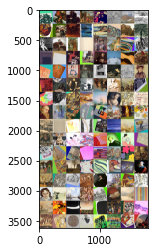

In [48]:
# get random training images to verify import worked
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

# show images
def imshow(img):
    img = img * our_ViT.default_cfg['std'][0] + our_ViT.default_cfg['mean'][0]  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

# show labels
print("Class: ", labels)

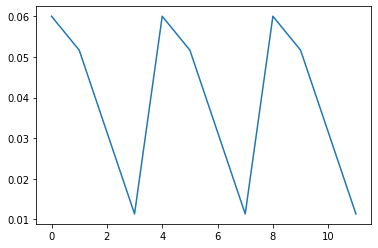

In [49]:
# set optimizer to use optimal learning rate
tuning_parameters = [parameter for parameter in our_ViT.parameters() if parameter.requires_grad]
optimal_lr = 0.06
optimizer = optim.SGD(tuning_parameters, lr=optimal_lr, momentum = .9)

# initialize scheduler to implement cosine learning rate decay during training
# Note: choose values for T_0 and num_epochs based on desired number of restarts during training
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, eta_min=0.003)

# visualize scheduler learning rate decay to occur during training based on num_epochs
lrs = []
num_epochs = 12

for epoch in range(num_epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

lrs = np.array(lrs)
plt.plot(lrs)

Starting training...
Learning rate:  [0.06]


  0%|          | 0/1925 [00:00<?, ?it/s]

[1,    20] loss: 3.216
[1,    40] loss: 3.204
[1,    60] loss: 3.190
[1,    80] loss: 3.178
[1,   100] loss: 3.165
[1,   120] loss: 3.152
[1,   140] loss: 3.140
[1,   160] loss: 3.131
[1,   180] loss: 3.120
[1,   200] loss: 3.111
[1,   220] loss: 3.103
[1,   240] loss: 3.094
[1,   260] loss: 3.082
[1,   280] loss: 3.077
[1,   300] loss: 3.068
[1,   320] loss: 3.063
[1,   340] loss: 3.058
[1,   360] loss: 3.048
[1,   380] loss: 3.049
[1,   400] loss: 3.035
[1,   420] loss: 3.035
[1,   440] loss: 3.029
[1,   460] loss: 3.018
[1,   480] loss: 3.022
[1,   500] loss: 3.016
[1,   520] loss: 3.010
[1,   540] loss: 3.009
[1,   560] loss: 2.998
[1,   580] loss: 2.995
[1,   600] loss: 2.993
[1,   620] loss: 2.990
[1,   640] loss: 2.983
[1,   660] loss: 2.985
[1,   680] loss: 2.985
[1,   700] loss: 2.978
[1,   720] loss: 2.976
[1,   740] loss: 2.975
[1,   760] loss: 2.969
[1,   780] loss: 2.967
[1,   800] loss: 2.968
[1,   820] loss: 2.961
[1,   840] loss: 2.965
[1,   860] loss: 2.954
[1,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[2,    20] loss: 2.877
[2,    40] loss: 2.873
[2,    60] loss: 2.870
[2,    80] loss: 2.866
[2,   100] loss: 2.875
[2,   120] loss: 2.863
[2,   140] loss: 2.876
[2,   160] loss: 2.867
[2,   180] loss: 2.872
[2,   200] loss: 2.864
[2,   220] loss: 2.877
[2,   240] loss: 2.865
[2,   260] loss: 2.860
[2,   280] loss: 2.871
[2,   300] loss: 2.865
[2,   320] loss: 2.867
[2,   340] loss: 2.867
[2,   360] loss: 2.869
[2,   380] loss: 2.850
[2,   400] loss: 2.861
[2,   420] loss: 2.856
[2,   440] loss: 2.853
[2,   460] loss: 2.861
[2,   480] loss: 2.856
[2,   500] loss: 2.859
[2,   520] loss: 2.854
[2,   540] loss: 2.855
[2,   560] loss: 2.861
[2,   580] loss: 2.852
[2,   600] loss: 2.861
[2,   620] loss: 2.859
[2,   640] loss: 2.860
[2,   660] loss: 2.851
[2,   680] loss: 2.850
[2,   700] loss: 2.849
[2,   720] loss: 2.852
[2,   740] loss: 2.857
[2,   760] loss: 2.854
[2,   780] loss: 2.855
[2,   800] loss: 2.855
[2,   820] loss: 2.853
[2,   840] loss: 2.842
[2,   860] loss: 2.836
[2,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[3,    20] loss: 2.821
[3,    40] loss: 2.822
[3,    60] loss: 2.826
[3,    80] loss: 2.823
[3,   100] loss: 2.818
[3,   120] loss: 2.836
[3,   140] loss: 2.821
[3,   160] loss: 2.812
[3,   180] loss: 2.824
[3,   200] loss: 2.828
[3,   220] loss: 2.824
[3,   240] loss: 2.821
[3,   260] loss: 2.815
[3,   280] loss: 2.818
[3,   300] loss: 2.811
[3,   320] loss: 2.824
[3,   340] loss: 2.821
[3,   360] loss: 2.825
[3,   380] loss: 2.838
[3,   400] loss: 2.821
[3,   420] loss: 2.820
[3,   440] loss: 2.821
[3,   460] loss: 2.818
[3,   480] loss: 2.831
[3,   500] loss: 2.815
[3,   520] loss: 2.824
[3,   540] loss: 2.825
[3,   560] loss: 2.821
[3,   580] loss: 2.826
[3,   600] loss: 2.815
[3,   620] loss: 2.822
[3,   640] loss: 2.816
[3,   660] loss: 2.815
[3,   680] loss: 2.819
[3,   700] loss: 2.817
[3,   720] loss: 2.817
[3,   740] loss: 2.817
[3,   760] loss: 2.824
[3,   780] loss: 2.817
[3,   800] loss: 2.814
[3,   820] loss: 2.814
[3,   840] loss: 2.821
[3,   860] loss: 2.817
[3,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[4,    20] loss: 2.802
[4,    40] loss: 2.801
[4,    60] loss: 2.817
[4,    80] loss: 2.814
[4,   100] loss: 2.807
[4,   120] loss: 2.796
[4,   140] loss: 2.802
[4,   160] loss: 2.805
[4,   180] loss: 2.800
[4,   200] loss: 2.801
[4,   220] loss: 2.820
[4,   240] loss: 2.807
[4,   260] loss: 2.812
[4,   280] loss: 2.803
[4,   300] loss: 2.808
[4,   320] loss: 2.809
[4,   340] loss: 2.808
[4,   360] loss: 2.809
[4,   380] loss: 2.806
[4,   400] loss: 2.809
[4,   420] loss: 2.817
[4,   440] loss: 2.818
[4,   460] loss: 2.813
[4,   480] loss: 2.809
[4,   500] loss: 2.809
[4,   520] loss: 2.799
[4,   540] loss: 2.801
[4,   560] loss: 2.798
[4,   580] loss: 2.803
[4,   600] loss: 2.813
[4,   620] loss: 2.807
[4,   640] loss: 2.810
[4,   660] loss: 2.802
[4,   680] loss: 2.810
[4,   700] loss: 2.805
[4,   720] loss: 2.798
[4,   740] loss: 2.808
[4,   760] loss: 2.801
[4,   780] loss: 2.808
[4,   800] loss: 2.798
[4,   820] loss: 2.803
[4,   840] loss: 2.806
[4,   860] loss: 2.802
[4,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[5,    20] loss: 2.805
[5,    40] loss: 2.804
[5,    60] loss: 2.793
[5,    80] loss: 2.788
[5,   100] loss: 2.803
[5,   120] loss: 2.803
[5,   140] loss: 2.805
[5,   160] loss: 2.797
[5,   180] loss: 2.798
[5,   200] loss: 2.793
[5,   220] loss: 2.798
[5,   240] loss: 2.804
[5,   260] loss: 2.795
[5,   280] loss: 2.803
[5,   300] loss: 2.796
[5,   320] loss: 2.801
[5,   340] loss: 2.794
[5,   360] loss: 2.800
[5,   380] loss: 2.794
[5,   400] loss: 2.804
[5,   420] loss: 2.796
[5,   440] loss: 2.794
[5,   460] loss: 2.794
[5,   480] loss: 2.804
[5,   500] loss: 2.800
[5,   520] loss: 2.798
[5,   540] loss: 2.801
[5,   560] loss: 2.792
[5,   580] loss: 2.787
[5,   600] loss: 2.796
[5,   620] loss: 2.790
[5,   640] loss: 2.800
[5,   660] loss: 2.799
[5,   680] loss: 2.791
[5,   700] loss: 2.786
[5,   720] loss: 2.793
[5,   740] loss: 2.801
[5,   760] loss: 2.792
[5,   780] loss: 2.791
[5,   800] loss: 2.798
[5,   820] loss: 2.799
[5,   840] loss: 2.795
[5,   860] loss: 2.798
[5,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[6,    20] loss: 2.782
[6,    40] loss: 2.774
[6,    60] loss: 2.786
[6,    80] loss: 2.791
[6,   100] loss: 2.783
[6,   120] loss: 2.783
[6,   140] loss: 2.776
[6,   160] loss: 2.775
[6,   180] loss: 2.770
[6,   200] loss: 2.778
[6,   220] loss: 2.774
[6,   240] loss: 2.770
[6,   260] loss: 2.779
[6,   280] loss: 2.774
[6,   300] loss: 2.782
[6,   320] loss: 2.777
[6,   340] loss: 2.777
[6,   360] loss: 2.779
[6,   380] loss: 2.781
[6,   400] loss: 2.787
[6,   420] loss: 2.779
[6,   440] loss: 2.781
[6,   460] loss: 2.782
[6,   480] loss: 2.790
[6,   500] loss: 2.774
[6,   520] loss: 2.779
[6,   540] loss: 2.791
[6,   560] loss: 2.779
[6,   580] loss: 2.772
[6,   600] loss: 2.776
[6,   620] loss: 2.781
[6,   640] loss: 2.772
[6,   660] loss: 2.770
[6,   680] loss: 2.776
[6,   700] loss: 2.770
[6,   720] loss: 2.781
[6,   740] loss: 2.787
[6,   760] loss: 2.779
[6,   780] loss: 2.776
[6,   800] loss: 2.773
[6,   820] loss: 2.767
[6,   840] loss: 2.782
[6,   860] loss: 2.769
[6,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[7,    20] loss: 2.768
[7,    40] loss: 2.766
[7,    60] loss: 2.760
[7,    80] loss: 2.772
[7,   100] loss: 2.769
[7,   120] loss: 2.769
[7,   140] loss: 2.768
[7,   160] loss: 2.769
[7,   180] loss: 2.762
[7,   200] loss: 2.771
[7,   220] loss: 2.771
[7,   240] loss: 2.773
[7,   260] loss: 2.767
[7,   280] loss: 2.777
[7,   300] loss: 2.769
[7,   320] loss: 2.767
[7,   340] loss: 2.758
[7,   360] loss: 2.766
[7,   380] loss: 2.755
[7,   400] loss: 2.769
[7,   420] loss: 2.765
[7,   440] loss: 2.756
[7,   460] loss: 2.774
[7,   480] loss: 2.767
[7,   500] loss: 2.769
[7,   520] loss: 2.768
[7,   540] loss: 2.758
[7,   560] loss: 2.768
[7,   580] loss: 2.765
[7,   600] loss: 2.764
[7,   620] loss: 2.779
[7,   640] loss: 2.766
[7,   660] loss: 2.760
[7,   680] loss: 2.760
[7,   700] loss: 2.770
[7,   720] loss: 2.763
[7,   740] loss: 2.759
[7,   760] loss: 2.765
[7,   780] loss: 2.768
[7,   800] loss: 2.772
[7,   820] loss: 2.765
[7,   840] loss: 2.765
[7,   860] loss: 2.772
[7,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[8,    20] loss: 2.770
[8,    40] loss: 2.761
[8,    60] loss: 2.763
[8,    80] loss: 2.770
[8,   100] loss: 2.769
[8,   120] loss: 2.772
[8,   140] loss: 2.761
[8,   160] loss: 2.762
[8,   180] loss: 2.763
[8,   200] loss: 2.768
[8,   220] loss: 2.775
[8,   240] loss: 2.773
[8,   260] loss: 2.762
[8,   280] loss: 2.764
[8,   300] loss: 2.754
[8,   320] loss: 2.777
[8,   340] loss: 2.757
[8,   360] loss: 2.759
[8,   380] loss: 2.754
[8,   400] loss: 2.761
[8,   420] loss: 2.774
[8,   440] loss: 2.764
[8,   460] loss: 2.763
[8,   480] loss: 2.764
[8,   500] loss: 2.756
[8,   520] loss: 2.750
[8,   540] loss: 2.756
[8,   560] loss: 2.765
[8,   580] loss: 2.765
[8,   600] loss: 2.762
[8,   620] loss: 2.761
[8,   640] loss: 2.764
[8,   660] loss: 2.761
[8,   680] loss: 2.765
[8,   700] loss: 2.769
[8,   720] loss: 2.760
[8,   740] loss: 2.755
[8,   760] loss: 2.763
[8,   780] loss: 2.764
[8,   800] loss: 2.762
[8,   820] loss: 2.757
[8,   840] loss: 2.764
[8,   860] loss: 2.750
[8,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[9,    20] loss: 2.758
[9,    40] loss: 2.754
[9,    60] loss: 2.755
[9,    80] loss: 2.765
[9,   100] loss: 2.758
[9,   120] loss: 2.765
[9,   140] loss: 2.764
[9,   160] loss: 2.763
[9,   180] loss: 2.759
[9,   200] loss: 2.761
[9,   220] loss: 2.754
[9,   240] loss: 2.763
[9,   260] loss: 2.751
[9,   280] loss: 2.763
[9,   300] loss: 2.758
[9,   320] loss: 2.759
[9,   340] loss: 2.760
[9,   360] loss: 2.757
[9,   380] loss: 2.755
[9,   400] loss: 2.755
[9,   420] loss: 2.771
[9,   440] loss: 2.762
[9,   460] loss: 2.758
[9,   480] loss: 2.755
[9,   500] loss: 2.758
[9,   520] loss: 2.758
[9,   540] loss: 2.759
[9,   560] loss: 2.758
[9,   580] loss: 2.746
[9,   600] loss: 2.755
[9,   620] loss: 2.746
[9,   640] loss: 2.760
[9,   660] loss: 2.767
[9,   680] loss: 2.757
[9,   700] loss: 2.761
[9,   720] loss: 2.757
[9,   740] loss: 2.762
[9,   760] loss: 2.758
[9,   780] loss: 2.755
[9,   800] loss: 2.745
[9,   820] loss: 2.753
[9,   840] loss: 2.756
[9,   860] loss: 2.758
[9,   880] 

  0%|          | 0/1925 [00:00<?, ?it/s]

[10,    20] loss: 2.758
[10,    40] loss: 2.758
[10,    60] loss: 2.750
[10,    80] loss: 2.753
[10,   100] loss: 2.747
[10,   120] loss: 2.748
[10,   140] loss: 2.754
[10,   160] loss: 2.747
[10,   180] loss: 2.747
[10,   200] loss: 2.755
[10,   220] loss: 2.754
[10,   240] loss: 2.747
[10,   260] loss: 2.751
[10,   280] loss: 2.748
[10,   300] loss: 2.745
[10,   320] loss: 2.756
[10,   340] loss: 2.748
[10,   360] loss: 2.754
[10,   380] loss: 2.758
[10,   400] loss: 2.749
[10,   420] loss: 2.753
[10,   440] loss: 2.750
[10,   460] loss: 2.748
[10,   480] loss: 2.735
[10,   500] loss: 2.749
[10,   520] loss: 2.742
[10,   540] loss: 2.750
[10,   560] loss: 2.739
[10,   580] loss: 2.750
[10,   600] loss: 2.747
[10,   620] loss: 2.736
[10,   640] loss: 2.742
[10,   660] loss: 2.740
[10,   680] loss: 2.750
[10,   700] loss: 2.743
[10,   720] loss: 2.748
[10,   740] loss: 2.750
[10,   760] loss: 2.755
[10,   780] loss: 2.743
[10,   800] loss: 2.752
[10,   820] loss: 2.747
[10,   840] loss

  0%|          | 0/1925 [00:00<?, ?it/s]

[11,    20] loss: 2.738
[11,    40] loss: 2.751
[11,    60] loss: 2.747
[11,    80] loss: 2.747
[11,   100] loss: 2.743
[11,   120] loss: 2.755
[11,   140] loss: 2.754
[11,   160] loss: 2.743
[11,   180] loss: 2.741
[11,   200] loss: 2.753
[11,   220] loss: 2.747
[11,   240] loss: 2.747
[11,   260] loss: 2.736
[11,   280] loss: 2.744
[11,   300] loss: 2.743
[11,   320] loss: 2.748
[11,   340] loss: 2.755
[11,   360] loss: 2.732
[11,   380] loss: 2.741
[11,   400] loss: 2.742
[11,   420] loss: 2.750
[11,   440] loss: 2.754
[11,   460] loss: 2.744
[11,   480] loss: 2.745
[11,   500] loss: 2.746
[11,   520] loss: 2.746
[11,   540] loss: 2.736
[11,   560] loss: 2.748
[11,   580] loss: 2.736
[11,   600] loss: 2.743
[11,   620] loss: 2.733
[11,   640] loss: 2.734
[11,   660] loss: 2.744
[11,   680] loss: 2.741
[11,   700] loss: 2.738
[11,   720] loss: 2.731
[11,   740] loss: 2.747
[11,   760] loss: 2.748
[11,   780] loss: 2.745
[11,   800] loss: 2.734
[11,   820] loss: 2.747
[11,   840] loss

  0%|          | 0/1925 [00:00<?, ?it/s]

[12,    20] loss: 2.752
[12,    40] loss: 2.738
[12,    60] loss: 2.737
[12,    80] loss: 2.741
[12,   100] loss: 2.737
[12,   120] loss: 2.745
[12,   140] loss: 2.737
[12,   160] loss: 2.737
[12,   180] loss: 2.738
[12,   200] loss: 2.738
[12,   220] loss: 2.738
[12,   240] loss: 2.744
[12,   260] loss: 2.742
[12,   280] loss: 2.735
[12,   300] loss: 2.740
[12,   320] loss: 2.743
[12,   340] loss: 2.741
[12,   360] loss: 2.739
[12,   380] loss: 2.734
[12,   400] loss: 2.743
[12,   420] loss: 2.736
[12,   440] loss: 2.722
[12,   460] loss: 2.746
[12,   480] loss: 2.755
[12,   500] loss: 2.737
[12,   520] loss: 2.742
[12,   540] loss: 2.750
[12,   560] loss: 2.743
[12,   580] loss: 2.746
[12,   600] loss: 2.727
[12,   620] loss: 2.731
[12,   640] loss: 2.740
[12,   660] loss: 2.745
[12,   680] loss: 2.746
[12,   700] loss: 2.733
[12,   720] loss: 2.742
[12,   740] loss: 2.739
[12,   760] loss: 2.743
[12,   780] loss: 2.733
[12,   800] loss: 2.751
[12,   820] loss: 2.740
[12,   840] loss

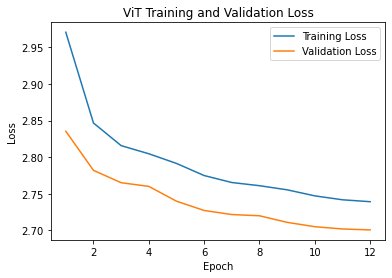

In [50]:
criterion = nn.CrossEntropyLoss()

# reset optimizer and scheduler
optimizer = optim.SGD(tuning_parameters, lr=optimal_lr, momentum = .9)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, eta_min=0.003)

# set ViT to desired weights
our_ViT.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth"))

# train the ViT using set optimizer and scheduler
finetune_ViT(our_ViT, trainloader=trainloader, validationloader=validationloader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs, scheduler=scheduler)

In [51]:
# load model with lowest validation loss
our_ViT.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/trained_ViT.pth"))

# test finetuned ViT
acc = test_ViT(our_ViT, testloader)

print(f"Results: {acc}% accuracy")

Results: 41.385196927204% accuracy


In [ ]:
# Print top categories per image (need to put into for loop if we want to use)

#top5_prob, top5_catid = torch.topk(probabilities, 5)
#for i in range(top5_prob.size(0)):
#    print(categories[top5_catid[i]], top5_prob[i].item())

In [ ]:
# --- FUNCTIONS NOT BEING USED --- #

In [ ]:
# stratified K-fold cross-validation function, if needed
def perform_cross_validation(model, L, validationset, lr_array, batchsize_array, criterion, num_epochs=5, scheduler=None):

    # create stratified folds to preserve class percentage representation within folds
    skf = StratifiedKFold(n_splits = L, shuffle = True, random_state = 1)

    # split validationset tuples into data and labels
    val_data, val_labels = zip(*validationset)

    accuracies = np.empty([len(lr_array), len(batchsize_array)])

    # run validation testing

    for i, lr in enumerate(lr_array):
        
        optimizer = optim.SGD(filter(lambda layer: layer.requires_grad, model.parameters()), lr=lr, momentum = .9)

        for j, batch_size in enumerate(batchsize_array):

            fold_val_acc = []
            print("LEARNING RATE: ", lr)
            print("BATCH SIZE: ", batch_size)

            for fold, (train_ids, test_ids) in enumerate(skf.split(val_data, val_labels)):

                # restore original weights for ViT and reset optimizer
                model.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth"))

                print("---STARTING NEW FOLD---")

                trainfold_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
                testfold_sampler = torch.utils.data.SubsetRandomSampler(test_ids)

                # define data loaders for training and testing data in this fold
                val_trainloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, sampler=trainfold_sampler)
                val_testloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, sampler=testfold_sampler)

                # train ViT on L-1 folds
                finetune_ViT(model, trainloader=val_trainloader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs, scheduler=scheduler)

                # test validation accuracy on remaining fold and keep track of accuracy per fold
                result = test_ViT(model, val_testloader)
                fold_val_acc.append(result)

            # take average accuracy across all folds for given learning rate
            print("---ALL FOLD ACCURACIES FOR CURRENT LR/BATCH_SIZE---")
            print(fold_val_acc)
            accuracies[i,j] = sum(fold_val_acc)/len(fold_val_acc)
            print(f"Average = {accuracies[i,j]}\n")


    # choose learning rate with best validation accuracy
    print("---FINAL AVG ACCURACIES PER LEARNING RATE/BATCH SIZE COMBO---")
    print("Accuracy Matrix: \n", accuracies)
    best_lr_ind, best_bs_ind = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
    
    optimal_lr = learning_rates[best_lr_ind]
    optimal_batch_size = batchsize_array[best_bs_ind]

    print(f"\nBest learning rate: {optimal_lr}")
    print(f"Best batch size: {optimal_batch_size}")
    return optimal_lr, optimal_batch_size